In [1]:
import os
from skimage.io import imread
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
%matplotlib inline
import numpy as np
from skimage.segmentation import mark_boundaries
from skimage.segmentation import find_boundaries
%load_ext autoreload
%autoreload 2
import sys
try:
    import lime
except:
    sys.path.append(os.path.join('..', '..')) # add the current directory
    import lime
from lime import lime_image
import time
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from pycocotools import mask as maskUtils
import skimage.io as io
import pylab
pylab.rcParams['figure.figsize'] = (8.0, 10.0)

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [2]:
def getCatId(imgId):
    for k in catId_to_imgId.keys():
        if imgId in catId_to_imgId[k]:
            return k
    print("imgId not found")
    raise Exception

In [6]:
used_cats = coco.loadCats(coco.getCatIds())
cat_names = [cat['name'] for cat in used_cats]
print('{} COCO categories used: \n{}\n'.format(len(used_cats), ' '.join(cat_names)))

80 COCO categories used: 
person bicycle car motorcycle airplane bus train truck boat traffic light fire hydrant stop sign parking meter bench bird cat dog horse sheep cow elephant bear zebra giraffe backpack umbrella handbag tie suitcase frisbee skis snowboard sports ball kite baseball bat baseball glove skateboard surfboard tennis racket bottle wine glass cup fork knife spoon bowl banana apple sandwich orange broccoli carrot hot dog pizza donut cake chair couch potted plant bed dining table toilet tv laptop mouse remote keyboard cell phone microwave oven toaster sink refrigerator book clock vase scissors teddy bear hair drier toothbrush



#### Preprocessing

In [4]:
dataDir=''
dataType='val2017'
annFile='annotations/instances_{}.json'.format(dataType)

In [5]:
# initialize COCO api for instance annotations
coco=COCO(annFile)

loading annotations into memory...
Done (t=0.79s)
creating index...
index created!


In [7]:
num_cats = 10

In [8]:
# Get categories with largest number of images to use
numCatImgs = []
for i in range(90):
    numCatImgs.append((i, len(coco.getImgIds(catIds=i))))
numCatImgs.sort(key=lambda x: x[1])
usedCatImgs = numCatImgs[-num_cats:]
minNumImgs = usedCatImgs[0][1]
used_ids = [tup[0] for tup in usedCatImgs]

used_cats = coco.loadCats(coco.getCatIds(catIds=used_ids))
cat_names = [cat['name'] for cat in used_cats]
print('{} COCO categories used: \n{}\n'.format(len(used_cats), ' '.join(cat_names)))

10 COCO categories used: 
person car truck bench handbag bottle cup bowl chair dining table



In [9]:
# Get all image ids to train on
# Create a dict so we can extract the label

all_imgIds = []
catId_to_imgId = {}

for id in used_ids:
    imgIds = coco.getImgIds(catIds=id)
    catId_to_imgId[id] = set(imgIds)
    all_imgIds.extend(imgIds)

#### Load Image

In [74]:
# catIds = coco.getCatIds(catNms=cat_names)
imgIds = coco.getImgIds(catIds=used_ids[0])
img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]

In [75]:
# Gets human-readable info about catId
i = img['id']
print(i)
x = coco.loadCats(getCatId(i))
print(x)

323496
[{'supercategory': 'outdoor', 'id': 15, 'name': 'bench'}]


In [76]:
print(img)

{'license': 2, 'file_name': '000000323496.jpg', 'coco_url': 'http://images.cocodataset.org/val2017/000000323496.jpg', 'height': 398, 'width': 500, 'date_captured': '2013-11-23 05:32:06', 'flickr_url': 'http://farm1.staticflickr.com/75/187735209_4dbca19b39_z.jpg', 'id': 323496}


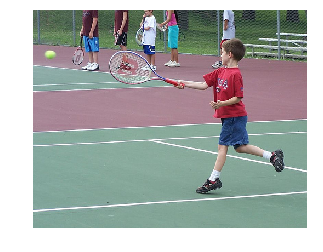

In [77]:
# load and display image
# I = io.imread('%s/images/%s/%s'%(dataDir,dataType,img['file_name']))
# use url to load image
I = io.imread(img['coco_url'])
plt.axis('off')
plt.imshow(I)
plt.show()

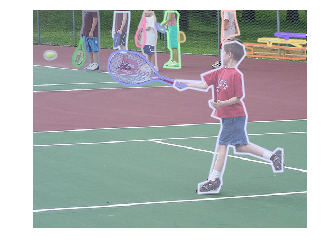

In [78]:
# load and display instance annotations
plt.imshow(I)
plt.axis('off')
annIds = coco.getAnnIds(imgIds=img['id'], catIds=coco.getCatIds(), iscrowd=None)
anns = coco.loadAnns(annIds)
coco.showAnns(anns)

In [79]:
_ann = anns[0]

In [80]:
print(coco.loadCats(_ann['category_id']))

[{'supercategory': 'sports', 'id': 37, 'name': 'sports ball'}]


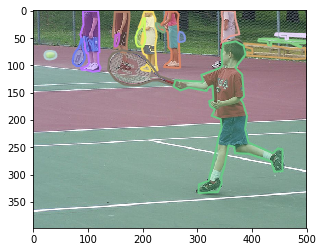

In [81]:
plt.imshow(I)
# ----------------------------------------------------------------------------------------------
ax = plt.gca()
ax.set_autoscale_on(False)
polygons = []
color = []
for ann in anns:
    c = (np.random.random((1, 3))*0.6+0.4).tolist()[0]
    if 'segmentation' in ann:
        if type(ann['segmentation']) == list:
            # polygon
            for seg in ann['segmentation']:
                poly = np.array(seg).reshape((int(len(seg)/2), 2))
                polygons.append(Polygon(poly))
                color.append(c)
#         else:
#             # mask
#             t = self.imgs[ann['image_id']]
#             if type(ann['segmentation']['counts']) == list:
#                 rle = maskUtils.frPyObjects([ann['segmentation']], t['height'], t['width'])
#             else:
#                 rle = [ann['segmentation']]
#             m = maskUtils.decode(rle)
#             img = np.ones( (m.shape[0], m.shape[1], 3) )
#             if ann['iscrowd'] == 1:
#                 color_mask = np.array([2.0,166.0,101.0])/255
#             if ann['iscrowd'] == 0:
#                 color_mask = np.random.random((1, 3)).tolist()[0]
#             for i in range(3):
#                 img[:,:,i] = color_mask[i]
#             ax.imshow(np.dstack( (img, m*0.5) ))
#     if 'keypoints' in ann and type(ann['keypoints']) == list:
#         # turn skeleton into zero-based index
#         sks = np.array(self.loadCats(ann['category_id'])[0]['skeleton'])-1
#         kp = np.array(ann['keypoints'])
#         x = kp[0::3]
#         y = kp[1::3]
#         v = kp[2::3]
#         for sk in sks:
#             if np.all(v[sk]>0):
#                 plt.plot(x[sk],y[sk], linewidth=3, color=c)
#         plt.plot(x[v>0], y[v>0],'o',markersize=8, markerfacecolor=c, markeredgecolor='k',markeredgewidth=2)
#         plt.plot(x[v>1], y[v>1],'o',markersize=8, markerfacecolor=c, markeredgecolor=c, markeredgewidth=2)

# Shades object mask in some gradient color
p = PatchCollection(polygons, facecolor=color, linewidths=0, alpha=0.4)
ax.add_collection(p)

# Creates solid color outline of object mask
p = PatchCollection(polygons, facecolor='none', edgecolors=color, linewidths=2)
ax.add_collection(p)

21
Bbox(x0=20.0, y0=73.92, x1=41.8, y1=89.35)


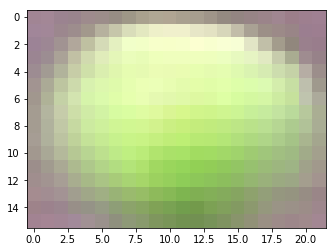

In [82]:
print(len(polygons))
_polygon = polygons[0]
b_box = _polygon.get_extents()
print(b_box)
x0, y0, width, height = b_box.bounds
x1, y1 = int(x0 + width + 0.5), int(y0 + height + 0.5)
x0, y0 = int(x0), int(y0)
plt.imshow(I[y0:y1, x0:x1])

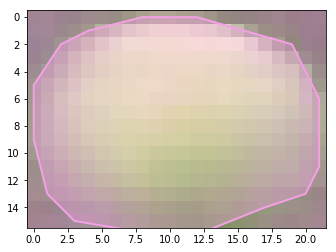

In [85]:
plt.imshow(I[y0:y1, x0:x1])
ax = plt.gca()
ax.set_autoscale_on(False)
p_gons = []
c_lor = []
for ann in np.array([anns[0]]):
    c = (np.random.random((1, 3))*0.6+0.4).tolist()[0]
    if 'segmentation' in ann:
        if type(ann['segmentation']) == list:
            # polygon
            
            alt_seg = ann['segmentation'].copy()
            for seg in alt_seg:
                for i in range(len(seg)):
                    if i % 2 == 0:
                        seg[i] = int(seg[i] - x0)
                    else:
                        seg[i] = int(seg[i] - y0)
            
            for seg in alt_seg:
                poly = np.array(seg).reshape((int(len(seg)/2), 2))
                p_gons.append(Polygon(poly))
                c_lor.append(c)

p = PatchCollection(p_gons, facecolor=c_lor, linewidths=0, alpha=0.4)
ax.add_collection(p)
p = PatchCollection(p_gons, facecolor='none', edgecolors=c_lor, linewidths=2)
ax.add_collection(p)

In [24]:
def getBboxImgs(polygons):
    bboxImgs = []
    for _polygon in polygons:
        b_box = _polygon.get_extents()
        x0, y0, width, height = b_box.bounds
        x1, y1 = int(x0 + width + 0.5), int(y0 + height + 0.5)
        x0, y0 = int(x0), int(y0)
        bboxImgs.append(I[y0:y1, x0:x1])
    return bboxImgs

In [132]:
print(_ann)

{'segmentation': [[144.69, 433.45, 147.33, 429.85, 143.0, 425.04, 142.52, 408.46, 143.24, 404.62, 155.26, 402.45, 150.93, 400.05, 150.45, 397.41, 154.78, 395.49, 156.94, 382.27, 162.23, 376.74, 158.86, 369.54, 158.86, 365.93, 166.31, 362.33, 172.08, 367.37, 171.84, 372.42, 178.32, 376.74, 181.69, 385.63, 180.97, 401.01, 178.8, 410.14, 156.7, 412.55, 152.37, 413.75, 153.34, 427.44, 155.98, 433.45, 144.93, 436.09]], 'area': 1356.3187499999997, 'iscrowd': 0, 'image_id': 361730, 'bbox': [142.52, 362.33, 39.17, 73.76], 'category_id': 1, 'id': 486785}


In [148]:
def getPolygonsAndObjectNames(anns):
    polygons, object_names = [], []
    for ann in anns:
        if 'segmentation' in ann:
            if type(ann['segmentation']) == list:
                # polygon
                cat_info = coco.loadCats(ann['category_id'])
                object_names.append(cat_info['name'])
                for seg in ann['segmentation']:
                    poly = np.array(seg).reshape((int(len(seg)/2), 2))
                    polygons.append(Polygon(poly))
    return polygons, object_names

In [ ]:
"""
Function to ..

Input Image -> Bbox image, label (cat_id), mask (object seg)
"""
def preprocess(image):
    I = io.imread(img['coco_url'])
    
    # Get obj seg/bbox annotations of img
    annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
    anns = coco.loadAnns(annIds)
    
    polygons, object_names = getPolygonsAndObjectNames(anns)
    bboxImgs = getBboxImgs(polygons)
    